In [5]:
with open('data.txt','r') as f:
    raw_text = f.read()

In [6]:
print(raw_text[100:200])

in the United States and
most other parts of the world at no cost and with almost no restrictions
wh


In [7]:
print(f"Total Number of characters: {len(raw_text)}")

Total Number of characters: 92874


## Word Tokenization

In [8]:
import re
vocab = list(set([item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',raw_text) if item.strip()]))
vocab[:20]

['finds',
 '[eBook',
 'full',
 'here',
 'week',
 'Buck',
 'sudden',
 'shift',
 'went',
 'prairie-dogs',
 'fambly',
 'receive',
 'mostly',
 'pilgrims',
 'expected',
 'degrees',
 'yuh!',
 'busy',
 'Marie',
 'these']

In [9]:
## Creating token IDs
idx2str = {idx:token for idx,token in enumerate(vocab)}
idx2str[len(idx2str)] = "<UNK>"
idx2str[len(idx2str)] = "<|eot|>"
str2idx = {token:idx for idx,token in idx2str.items()}

print(f"Number of tokens::{len(idx2str)}")

Number of tokens::3361


In [10]:
## Creating a custom tokenizer class

class CustomTokenizerV1():
    def __init__(self, vocab, special_tokens = ["<|eot|>","<|cls|>","<|sep|>"]):
        self.idx2str = {idx:token for idx,token in enumerate(vocab)}
        ## adding special tokens
        self.idx2str[len(self.idx2str)] = "<|unk|>"
        for tok in special_tokens:
            self.idx2str[len(self.idx2str)] = tok
        self.str2idx = {token:idx for idx,token in self.idx2str.items()}
        assert len(self.idx2str) == len(self.str2idx)
        print(f"Total Number of tokens::{len(self.idx2str)}", end = "\n\n")
        print(f"-"*10 + " "+ "Special Tokens" + "-"*10, end = '\n\n')
        for tok in special_tokens:
            print(f"Token ID for {tok}::{self.str2idx[tok]}")

    def encode(self,seq):
        preprocessed = [item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',seq) if item.strip()]
        tokenized = [self.str2idx.get(tok,self.str2idx.get("<|unk|>")) for tok in preprocessed]
        return tokenized

    def decode(self, tok_seq):
        text = ' '.join([self.idx2str.get(item) for item in tok_seq])
        text = re.sub(r'([,.”?/()\'’]|\s)',r'\1',text)
        return text


In [11]:
tokenizer = CustomTokenizerV1(vocab)
seq = "How are you doing charles?"
ids = tokenizer.encode(seq)
tokenizer.decode(ids)



Total Number of tokens::3363

---------- Special Tokens----------

Token ID for <|eot|>::3360
Token ID for <|cls|>::3361
Token ID for <|sep|>::3362


'How are you doing <|unk|> ?'

In [12]:
## using sub-word tokenization from tiktoken (Byte Pair Encoding)
import tiktoken
tokenizer_subword = tiktoken.get_encoding("gpt2")
seq = "How are you doing charles?<|endoftext|>"
ids = tokenizer_subword.encode(seq, allowed_special={"<|endoftext|>"})
for id_ in ids:
    print(tokenizer_subword.decode([id_]))


How
 are
 you
 doing
 char
les
?
<|endoftext|>


## BPE Encoding (Sub-Word Tokenization)

In [13]:

with open('data.txt','r') as f:
    raw_text = f.read()

encoded = tokenizer_subword.encode(raw_text)
print(f"Total number of tokens post encoding::{len(encoded)}")

Total number of tokens post encoding::29698


In [14]:
context_size = 5
X = encoded[:context_size]
y = encoded[1:context_size+1]
print(f"train samples::{X}")
print(f"test samples::{y}")

train samples::[464, 4935, 20336, 46566, 286]
test samples::[4935, 20336, 46566, 286, 1649]


## Creating DataLoader with Sub-Word tokenization

In [15]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from torch import tensor, arange

class GPTDatasetV1(Dataset):

    def __init__(self, txt, context_size, stride, tokenizer):
        self.input_ids = []
        self.output_ids = []
        ## tokenizing the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        ## looping over the sequences
        for i in range(0, len(token_ids) - context_size, stride):
            input_chunk = token_ids[i:i+context_size]
            target_chunk = token_ids[i+1:i+context_size+1]
            self.input_ids.append(tensor(input_chunk))
            self.output_ids.append(tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {"x":self.input_ids[idx],
                "y":self.output_ids[idx]}


def get_dataloader(txt, batch_size = 4, context_size = 1024, stride = 512,
                   shuffle = True, drop_last = True, num_workers = 0):
    '''Creates a dataloader object'''
    ## loading the sub-word tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    ## creating dataset oject
    dataset = GPTDatasetV1(txt, tokenizer=tokenizer,
                           context_size=context_size, stride=stride)
    ## creating the dataloader object
    dataloader = DataLoader(dataset,batch_size=batch_size,
                            drop_last=drop_last,
                            num_workers=num_workers,
                            shuffle = shuffle)
    return dataloader

In [16]:
loader = get_dataloader(raw_text, batch_size=8, 
                        context_size=1024, stride=512)


In [17]:
for batch in loader:
    print("Input Tensor",batch["x"],f"Input Tensor Shape::{batch['x'].shape}",sep = "\n")
    print("--"*10)
    print("Output Tensor",batch["y"],f"Output Tensor Shape::{batch['y'].shape}",sep = "\n")
    break

Input Tensor
tensor([[  766,   543,   886,  ...,   481,   307,  3377],
        [  198,   198,  4366,  ..., 36454,  2944, 21749],
        [  198, 11274,  8458,  ...,  4922,    13,   198],
        ...,
        [42237,    13,  1002,  ...,  2581,    11,   286],
        [  290,   612,   356,  ..., 23448,    13,  5660],
        [ 3088,   284,  1011,  ...,  5945,   286, 33503]])
Input Tensor Shape::torch.Size([8, 1024])
--------------------
Output Tensor
tensor([[  543,   886,  4962,  ...,   307,  3377,   287],
        [  198,  4366,  4919,  ...,  2944, 21749,    13],
        [11274,  8458,   438,  ...,    13,   198,   198],
        ...,
        [   13,  1002,   281,  ...,    11,   286,   262],
        [  612,   356,  7228,  ...,    13,  5660, 35073],
        [  284,  1011,   257,  ...,   286, 33503,   735]])
Output Tensor Shape::torch.Size([8, 1024])


## Token Embedding

In [18]:

from torch.nn import Embedding, LSTM, RNN
from torch.optim import Adam, RMSprop, SGD
vocab_size = tokenizer_subword.n_vocab
embedding_dim = 768

embedding_layer = Embedding(vocab_size, embedding_dim)
embedding_layer.weight.shape

torch.Size([50257, 768])

In [19]:
embedding_layer(tensor([[1,2,3, 9 ,8 ,22]])).shape

torch.Size([1, 6, 768])

In [20]:
embedding_layer(batch['x']).shape

torch.Size([8, 1024, 768])

## Positional Embedding/Encoding

In [21]:
## Positional Embeddings (Absolute Positional Encoding)
context_size = 1024
embedding_dim = 768
pos_embedding_layer = Embedding(context_size, embedding_dim)

In [22]:
pos_embedding_layer(arange(context_size)).shape

torch.Size([1024, 768])

In [23]:
embeddings = embedding_layer(batch['x'])
print(f"Embedding Shape::{embeddings.shape}")
pos_embeddings = pos_embedding_layer(arange(context_size))
print(f"Positional Embedding::{pos_embeddings.shape}")
final_input_embedding = embeddings + pos_embeddings
print(f"Embeddings + Positional Embedding::{final_input_embedding.shape}") # this will be the input to the self attention layer

Embedding Shape::torch.Size([8, 1024, 768])
Positional Embedding::torch.Size([1024, 768])
Embeddings + Positional Embedding::torch.Size([8, 1024, 768])


## Attention Mechanisms

### 1. Simplified Attention Mechanism **(No Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**

In [24]:
text = "I see skies of green, red roses too"
token_ids = tokenizer_subword.encode(text)

In [25]:
print(f"Token IDs::{token_ids}")
print(f"Decoded Token IDs::{tokenizer_subword.decode(token_ids)}")

Token IDs::[40, 766, 24091, 286, 4077, 11, 2266, 42152, 1165]
Decoded Token IDs::I see skies of green, red roses too


In [26]:
## Creating an embedding layer
VOCAB_SIZE = tokenizer_subword.n_vocab # Vocab Size of the sub-word tokenizer
EMBEDDING_SIZE = 3 # For Simplicity embedding each token into a 3-Dimensional Space
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

In [27]:
## Creating Embedding of our tokens
embeddings = embedding_layer(tensor(token_ids))
embeddings.shape

torch.Size([9, 3])

In [28]:
embeddings = embeddings.detach().numpy().reshape(-1,3)
for emb, tok in zip(embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")



I --> [1.7113123 1.1494173 1.1294724]
see --> [ 1.0290926  -0.6932279   0.41335833]
skies --> [1.1129781 2.212876  1.1477424]
of --> [-0.05231377 -0.57624644  0.5519367 ]
green --> [-0.5591265   0.25379056  1.84578   ]
, --> [ 0.8442495 -1.5011795  1.9497161]
red --> [-1.4475088 -0.7225396  0.7565808]
roses --> [ 1.7255375   0.29635075 -0.10784396]
too --> [ 2.4827342  -0.42795664 -1.2683378 ]


/Users/sauravnaik/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


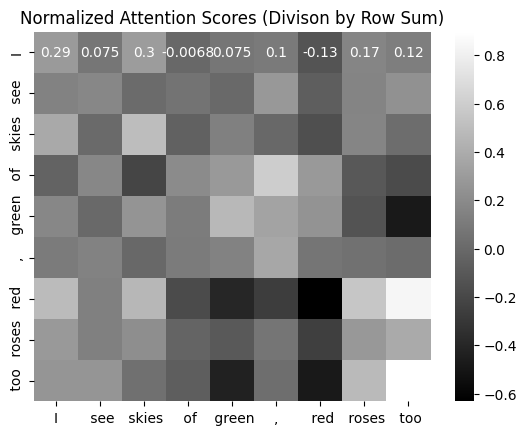

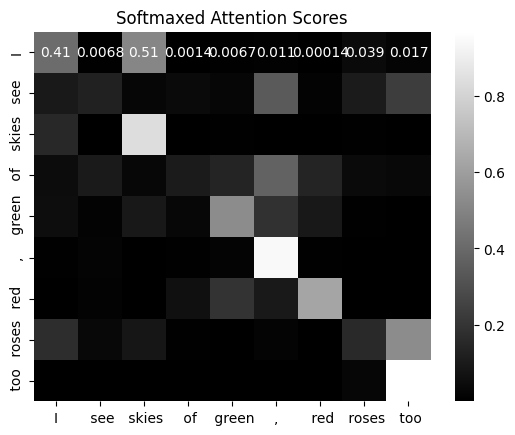

In [29]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def softmax(mat):
    '''Softmax as implemented in pytorch'''
    num_ =  np.exp(mat-np.max(mat, axis=1, keepdims=True))
    denom_ = np.sum(num_, axis=1, keepdims=True)
    return num_/denom_


labels = [tokenizer_subword.decode([i]) for i in token_ids]
attention_scores = embeddings @ embeddings.T
# Normalizing the attention scores by dividing by sum of the corresponding rows
normalized_attention_scores = attention_scores/np.sum(attention_scores, axis=1, keepdims=True)
## Plotting the HeatMap for the Normalized Attention Scores
sns.heatmap(normalized_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Normalized Attention Scores (Divison by Row Sum)")
plt.show();

softmaxed_attention_scores = softmax(attention_scores)
sns.heatmap(softmaxed_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Softmaxed Attention Scores")
plt.show();

In [30]:
context_embeddings = softmaxed_attention_scores @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")

I --> [1.3874683 1.5806664 1.0589525]
see --> [ 1.3348125  -0.53237635  0.6232031 ]
skies --> [1.2012032 2.0276275 1.1386508]
of --> [ 0.39446387 -0.636017    1.224982  ]
green --> [-0.06086532  0.02856404  1.5997467 ]
, --> [ 0.8187338 -1.4193703  1.8913684]
red --> [-0.9092257  -0.58631164  1.067176  ]
roses --> [ 2.0189228   0.15383333 -0.34451917]
too --> [ 2.454287   -0.40463513 -1.2223805 ]


#### Same stuff but using pytorch

In [31]:
import torch
attn_scores = embeddings @ embeddings.T
attn_weights = torch.softmax(tensor(attn_scores), dim = -1)
context_embeddings = attn_weights @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

I --> [1.3874683 1.5806664 1.0589525]
see --> [ 1.3348125  -0.53237635  0.6232031 ]
skies --> [1.2012032 2.0276275 1.1386508]
of --> [ 0.39446387 -0.63601696  1.224982  ]
green --> [-0.0608653   0.02856402  1.5997468 ]
, --> [ 0.81873393 -1.4193704   1.8913686 ]
red --> [-0.9092257  -0.58631164  1.067176  ]
roses --> [ 2.0189226   0.15383333 -0.34451914]
too --> [ 2.4542873 -0.4046352 -1.2223806]


#### We observe our calculations give us similar results

#### Why the need for Trainable Weights?

### 2. Self Attention Mechanism **(With Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**
- Creating *Query*, *Key* and *Value* matrices **(Trainable Weights)**

In [32]:
torch.manual_seed(123)
d_in = EMBEDDING_SIZE
d_out = 2
w_Q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Query Weight Matrix
w_K = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Key Weight Matrix
w_V = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Value Weight Matrix

In [33]:
embeddings_tensors = tensor(embeddings)

In [34]:
query = embeddings_tensors @ w_Q
key = embeddings_tensors @ w_K
value = embeddings_tensors @ w_V
query

tensor([[ 0.8796,  2.6542],
        [ 0.1608,  0.4124],
        [ 0.9714,  3.0932],
        [-0.1197,  0.0545],
        [ 0.0348,  1.4853],
        [ 0.0164,  1.0919],
        [-0.5545, -0.5896],
        [ 0.5776,  1.0020],
        [ 0.5336, -0.1112]])

#### Can also be done in a different way

In [35]:
## concating query, key and value weights horizontally
q_k_v = torch.concat([w_Q,w_K,w_V], dim = -1)
print(f"Inputs shape::{embeddings_tensors.shape}")
print(f"q_k_v shape::{q_k_v.shape}")
outputs = embeddings_tensors@q_k_v
print(f"Outputs shape::{outputs.shape}")

Inputs shape::torch.Size([9, 3])
q_k_v shape::torch.Size([3, 6])
Outputs shape::torch.Size([9, 6])


In [36]:
query_new, key_new, value_new = torch.hsplit(outputs,3)
query_new==query

tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False]])

In [37]:
attn_scores = query_new @ key_new.T
scaled_attn_scores = attn_scores/torch.math.sqrt(w_K.shape[-1]) ## scaled attention scores
attn_weights = torch.softmax(scaled_attn_scores, dim = -1)

context_vectors = attn_weights @ value_new

print("Context Vectors", end = "\n")
print("--"*10, end='\n\n')
for emb, tok in zip(context_vectors,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

Context Vectors
--------------------

I --> [0.7957879 1.9220514]
see --> [0.27333757 1.0353588 ]
skies --> [0.82855  1.960871]
of --> [0.14559208 0.7469482 ]
green --> [0.57743907 1.6006691 ]
, --> [0.46911147 1.4134212 ]
red --> [-0.00611178  0.32325485]
roses --> [0.49385783 1.4620982 ]
too --> [0.1581789 0.7853605]


#### Why we divide the attention scores by sqrt(key dimension)?
1. **Stability in Learning**

### Causal Attention Layer

In [38]:
CONTEXT_SIZE = 5
inp_text = "Hello How are you?"
embedding_layer = Embedding(tokenizer_subword.n_vocab, 768)
pos_embedding_layer = Embedding(CONTEXT_SIZE, 768)
inp_tok =tokenizer_subword.encode(inp_text)
embeddings = embedding_layer(tensor([inp_tok]))
pos_emb = pos_embedding_layer(torch.arange(tensor(embeddings.shape[1])))
inp_embedding = embeddings + pos_emb


In [39]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length,
                 dropout = 0, q_k_v_bias = False,
                 causal_mask = True):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.dropout = torch.nn.Dropout(dropout)
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        # batch, seq_len, d_in = x.shape
        q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        # print(f"q_k_v shape: {q_k_v.shape}")
        combined_transform = x @ q_k_v
        # print(f"combined_transform shape: {combined_transform.shape}")
        query, key, value = torch.split(combined_transform,self.W_key.shape[-1], dim=2)
        attn_weights = query @ key.transpose(1,2) # (batch X seq_len X seq_len)
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)
        scaled_attn_weights = attn_weights/key.shape[-1]**0.5
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))
        return {"context_vectors": attn_scores @ value,
                "attn_scores": attn_scores} # context rich vectors (batch X seq_len X embedding_dim)


In [40]:
# inp_embedding = torch.concat([inp_embedding]*5, dim = 0)
c_attn = CausalAttention(*(768,768,5), causal_mask=True)
# c_attn(inp_embedding)

In [41]:
for param in c_attn.parameters():
    print(param.shape)

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])


In [42]:
c_attn(inp_embedding)

{'context_vectors': tensor([[[  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [-34.3452, -44.6836, -41.2677,  ..., -44.9336, -21.9690, -32.7346]]],
        grad_fn=<UnsafeViewBackward0>),
 'attn_scores': tensor([[[1., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)}

### Muti Head Attention

In [43]:
## applies heads sequentially
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length, num_heads, dropout = 0.0, q_k_v_bias = False):
        super().__init__()
        self.out_layer = torch.nn.Parameter(torch.rand(num_heads * d_out, d_out))
        self.heads = torch.nn.ModuleList([CausalAttention(d_in, d_out,context_length) for _ in range(num_heads)])
    def forward(self, x):
        concated_context_vecs = torch.concat([head(x)['context_vectors'] for head in self.heads], dim=-1)
        return concated_context_vecs @ self.out_layer


In [44]:
multi_attn = MultiHeadAttentionWrapper(768,3,5,10, dropout=0.5)

In [45]:
out_ = multi_attn(inp_embedding)
out_.shape

torch.Size([1, 5, 3])

#### Improving the MultiHead Attention By implementing the heads parallely

In [46]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads,dropout = 0.0, causal_mask = True):
        super().__init__()
        self.num_heads = num_heads
        self.d_out = d_out
        self.W_query = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.dropout = torch.nn.Dropout(dropout)
        self.out_project = torch.nn.Parameter(torch.rand(num_heads *d_out, d_out, dtype=torch.float32))
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        # q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        # Reshape for multi-head attention
        queries = queries.view(batch_size, seq_len, self.num_heads, self.d_out)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.d_out)
        values = values.view(batch_size, seq_len, self.num_heads, self.d_out)

        # Transpose the shapes (Grouping with respect to number of heads)
        queries = queries.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        keys = keys.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        values = values.transpose(1,2)# (batch X num_heads X seq_len X d_out)

        # Calculating Attention Scores
        attn_weights = queries @ keys.transpose(2,3) # (batch X num_heads X seq_len X seq_len)

        # Adding the Causal Mask
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool()[:seq_len,:seq_len],-torch.inf)# (batch X num_heads X seq_len X seq_len)

        # Scaling and Softmax the atten scores
        scaled_attn_weights = attn_weights/keys.shape[-1]**0.5# (batch X num_heads X seq_len X seq_len)
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))# (batch X num_heads X seq_len X seq_len)
        # print(f"Attention Shape::{attn_scores.shape}")
        # print(f"Max val in attn score matrix:: {attn_scores.max().detach().numpy()}")
        context_vectors = (attn_scores @ values).transpose(1,2)# (batch X seq_len X num_heads X d_out)
        concated_context_vectors = context_vectors.contiguous().view(batch_size,seq_len,-1)# (batch X seq_len X num_heads * d_out)
        context_vectors = concated_context_vectors @ self.out_project# (batch X seq_len X d_out)
        return {"context_vectors": context_vectors,
                "attn_scores": attn_scores} # context vectors (batch X seq_len X embedding_dim)
                                            # attn_scores (batch X num_heads X seq_len X seq_len)



In [47]:
inp_embedding.shape

torch.Size([1, 5, 768])

In [48]:
# making batch size = 5
inp_embedding_new = torch.concat([inp_embedding]*10, dim =0)
inp_embedding_new += torch.rand(size = (inp_embedding_new.shape)) # making values in each batch different
inp_embedding_new.shape

torch.Size([10, 5, 768])

In [49]:
multi_attn = MultiHeadAttention(d_in=768,
                                d_out = 751,
                                num_heads=2,
                                context_length=5,
                                dropout=0.4)
# multi_attn.eval()

In [50]:
multi_attn(inp_embedding_new)['context_vectors'].shape

torch.Size([10, 5, 751])

In [51]:
attn_scores = multi_attn(inp_embedding_new)['attn_scores']

In [52]:
(attn_scores.shape)

torch.Size([10, 2, 5, 5])

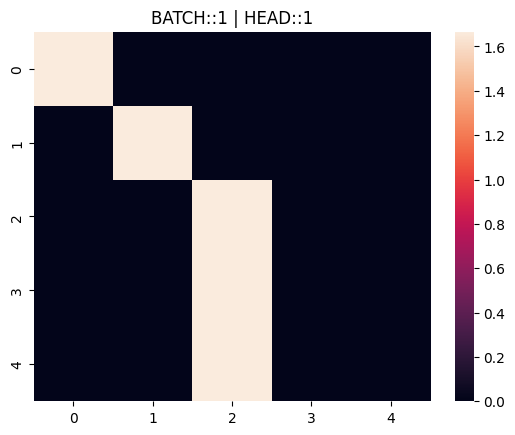

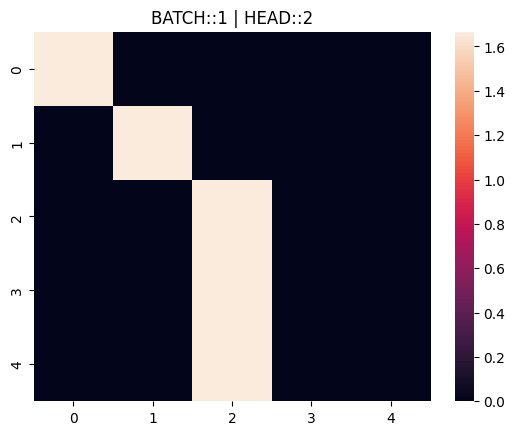

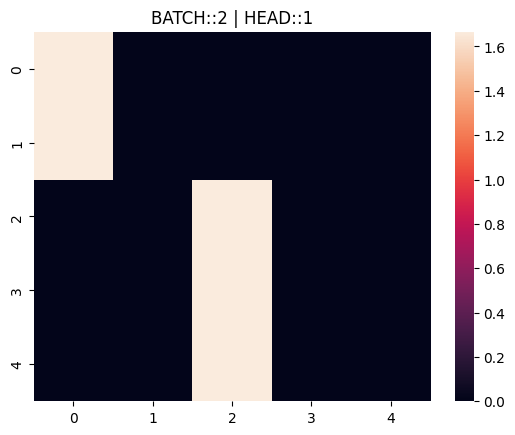

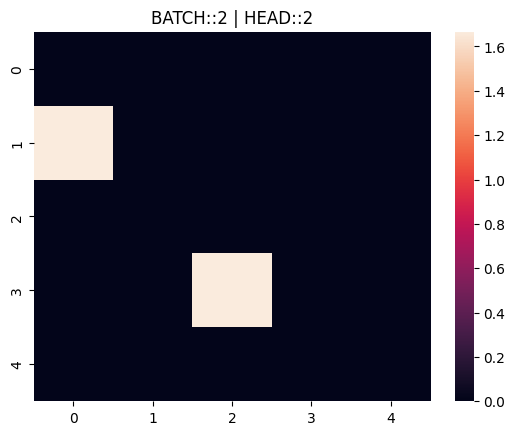

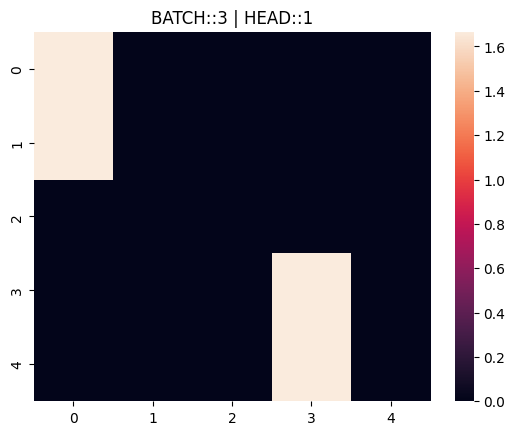

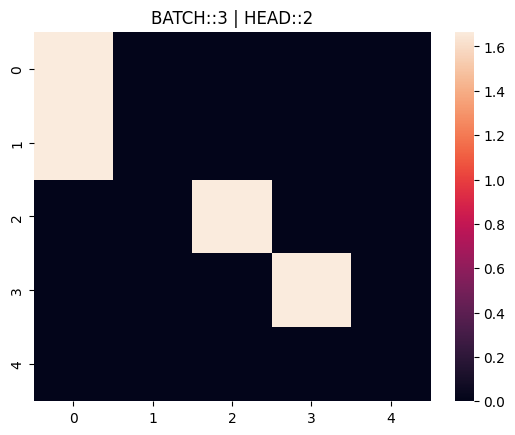

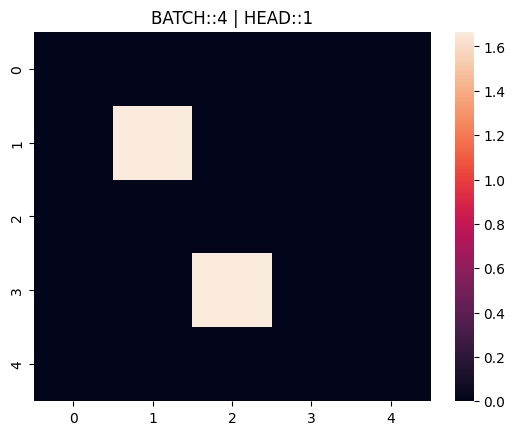

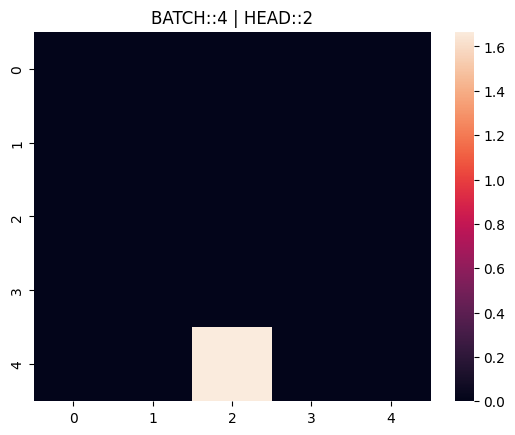

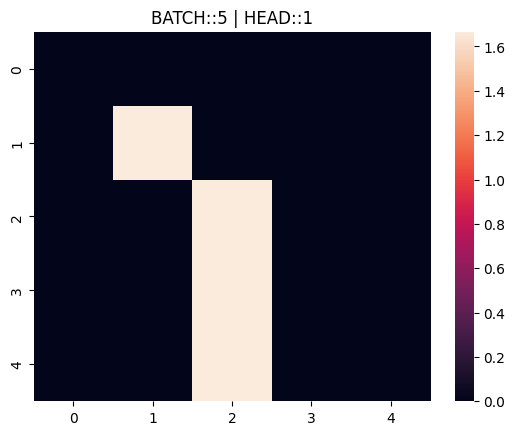

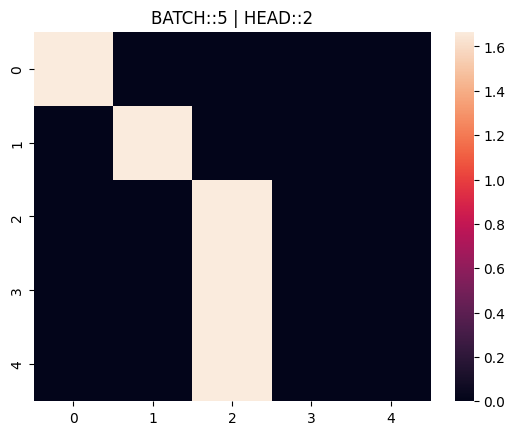

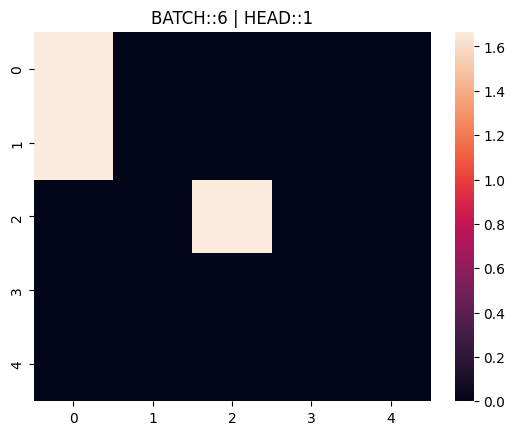

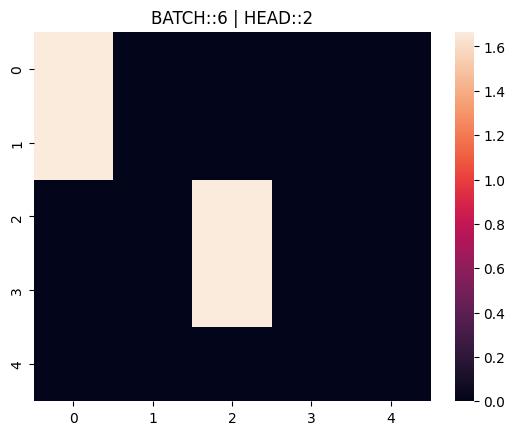

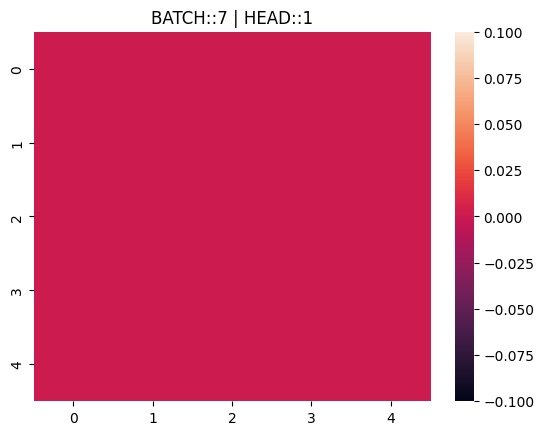

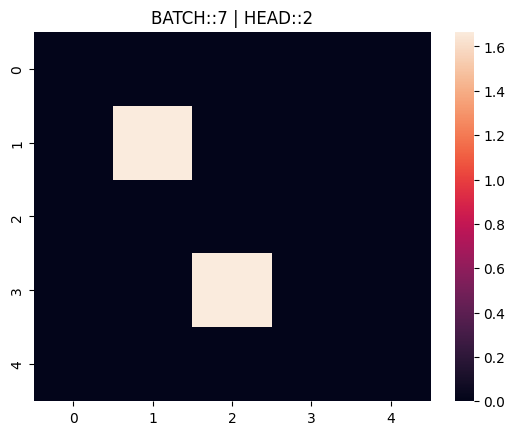

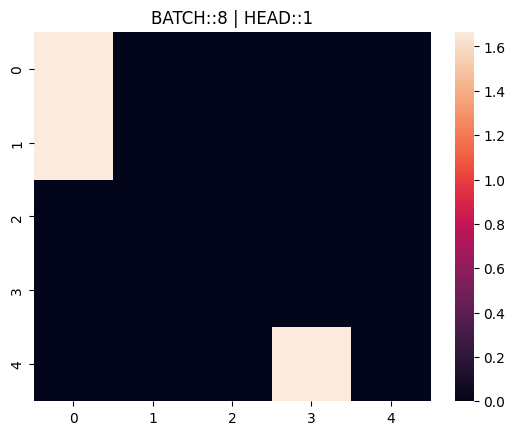

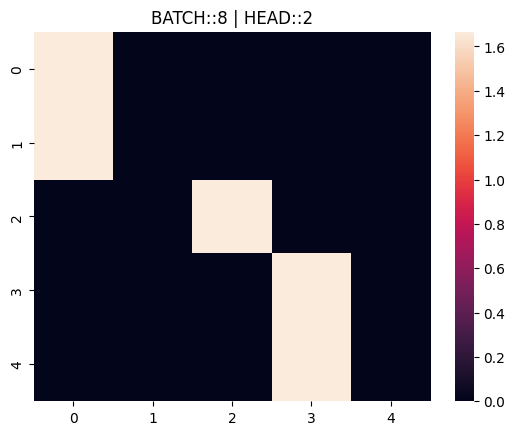

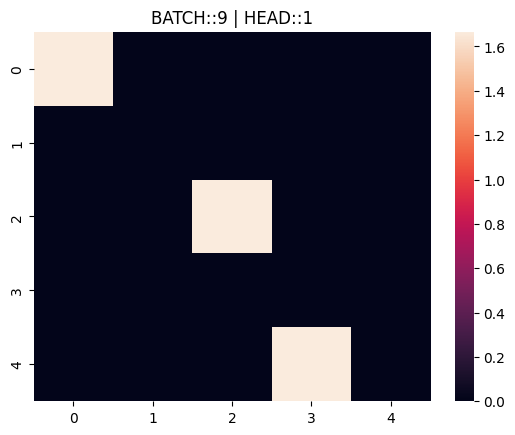

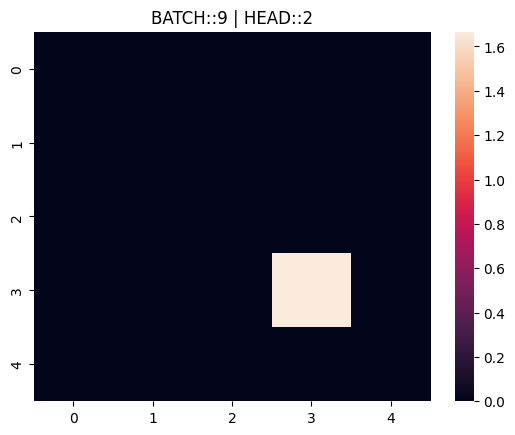

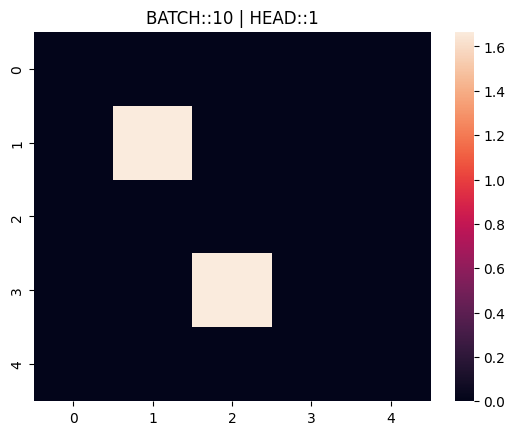

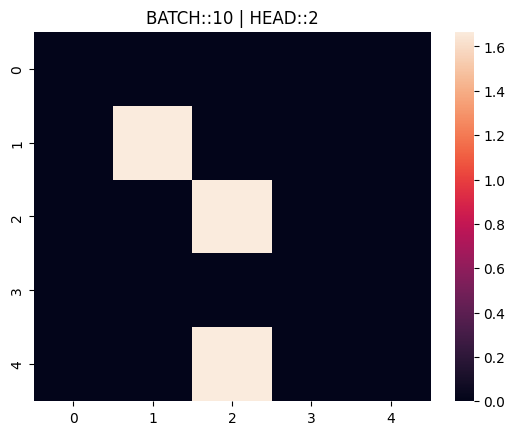

In [53]:
batch_size, num_heads, _, _= attn_scores.shape
for batch in range(batch_size):
    for head in range(num_heads):
        sns.heatmap(attn_scores[batch, head,:,:].detach())
        plt.title(f"BATCH::{batch+1} | HEAD::{head + 1}")
        plt.show()

### GPT 2 Model

In [54]:
# configuration dictionary
GPT2_CONFIG = {
                "vocab_size":50257,
                "context_len":1024,
                "embedding_dim":768,
                "dropout_rate":0.0,
                "n_layers":12,
                "n_heads":12,
                "q_k_v_bias":False,
                "drop_rate":0.4
              }

In [55]:
class DummyGPT2(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.emb_layer = torch.nn.Embedding(self.config.get('vocab_size'),
                                            self.config.get('embedding_dim'))
        self.pos_enc_layer = torch.nn.Embedding(self.config.get("context_len"),
                                                self.config.get("embedding_dim"))
        self.drop_emb_layer = torch.nn.Dropout(self.config.get('dropout_rate'))

        # Transformer Blocks
        self.trf_blocks = torch.nn.Sequential(*[DummyTransformerlock(GPT2_CONFIG) \
                                                for _ in range(self.config.get("n_layers"))])
        # LayerNorm
        self.final_norm = DummyLayerNorm(GPT2_CONFIG)

        # output head
        self.out_head = torch.nn.Linear(self.config.get("embedding_dim"),
                                        self.config.get("vocab_size"))

    def forward(self, inp_):
        batch_size, seq_len = inp_.shape
        tok_emb = self.emb_layer(inp_)
        pos_emb = self.pos_enc_layer(torch.arange(seq_len, device = inp_.device))
        inp_emb = tok_emb + pos_emb
        inp_emb = self.drop_emb_layer(inp_emb)
        x = self.trf_blocks(inp_emb)
        x = self.final_norm(x)
        logits = self.out_head(x) # (batch_size X seq_len X vocab_size)
        return logits



class DummyTransformerlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        pass
    def forward(self, x):
        ## TODO:: add code
        return x

class DummyLayerNorm(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        pass
    def forward(self, x):
        return x


In [56]:
gpt_model = DummyGPT2(GPT2_CONFIG)

In [57]:
gpt_model

DummyGPT2(
  (emb_layer): Embedding(50257, 768)
  (pos_enc_layer): Embedding(1024, 768)
  (drop_emb_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): DummyTransformerlock()
    (1): DummyTransformerlock()
    (2): DummyTransformerlock()
    (3): DummyTransformerlock()
    (4): DummyTransformerlock()
    (5): DummyTransformerlock()
    (6): DummyTransformerlock()
    (7): DummyTransformerlock()
    (8): DummyTransformerlock()
    (9): DummyTransformerlock()
    (10): DummyTransformerlock()
    (11): DummyTransformerlock()
  )
  (final_norm): DummyLayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=True)
)

In [58]:
import torchinfo

In [59]:
torchinfo.summary(gpt_model)

Layer (type:depth-idx)                   Param #
DummyGPT2                                --
├─Embedding: 1-1                         38,597,376
├─Embedding: 1-2                         786,432
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─DummyTransformerlock: 2-1         --
│    └─DummyTransformerlock: 2-2         --
│    └─DummyTransformerlock: 2-3         --
│    └─DummyTransformerlock: 2-4         --
│    └─DummyTransformerlock: 2-5         --
│    └─DummyTransformerlock: 2-6         --
│    └─DummyTransformerlock: 2-7         --
│    └─DummyTransformerlock: 2-8         --
│    └─DummyTransformerlock: 2-9         --
│    └─DummyTransformerlock: 2-10        --
│    └─DummyTransformerlock: 2-11        --
│    └─DummyTransformerlock: 2-12        --
├─DummyLayerNorm: 1-5                    --
├─Linear: 1-6                            38,647,633
Total params: 78,031,441
Trainable params: 78,031,441
Non-trainable params: 0

In [60]:
text = ["Hello How are you",
        "Hey are you thirsty",
        "DO your best buddy"]
# have made sure that each batch has 4 tokens
# if not that needs to be handeled using padding
inp_tokens = tokenizer_subword.encode_batch(text)
gpt_model(torch.tensor(inp_tokens))

tensor([[[ 1.2284, -0.4354, -0.0451,  ..., -0.4942, -1.0726, -1.2486],
         [-0.2800,  0.2542, -0.3948,  ..., -0.9709,  0.2893, -0.3089],
         [ 0.3929,  0.7372,  0.1150,  ..., -0.2027,  0.6534,  0.2919],
         [-0.8358,  0.2261, -0.0887,  ...,  1.4818, -1.7524, -1.3620]],

        [[ 0.7311, -0.3459,  1.3259,  ...,  0.3655, -0.6539, -0.6194],
         [ 0.5093, -0.7993,  0.1675,  ..., -1.1081,  0.9756,  1.0890],
         [-0.5865,  1.2916, -0.2720,  ...,  1.0786, -0.9453, -1.9825],
         [-0.3628,  1.3632, -0.9237,  ...,  1.1073, -0.7341,  1.3375]],

        [[ 0.0572,  0.1553,  0.0095,  ...,  0.1298, -0.8693, -0.4992],
         [-0.1554,  0.8274, -1.3559,  ..., -0.4688, -0.2252, -0.3477],
         [-0.2913,  0.9111, -0.4002,  ..., -0.9396, -0.2297, -0.2273],
         [ 0.8517,  0.3166,  1.3191,  ...,  1.5358, -0.0162, -0.6474]]],
       grad_fn=<ViewBackward0>)

### Layer Normalization

In [61]:
batch = torch.randn(2,5)
weight = torch.randn(5,6)
out = torch.nn.functional.relu(batch@weight)
out

tensor([[0.0000, 1.9334, 0.0000, 4.4976, 0.0000, 0.0000],
        [0.6159, 0.0000, 0.0000, 0.5307, 0.0000, 0.0000]])

In [62]:
mean = out.mean(dim = -1, keepdim=True)
var = out.var(dim = -1, keepdim=True)
out_norm = (out-mean)/var**0.5


In [63]:
class LayerNorm(torch.nn.Module):

    def __init__(self, embedding_dim):
        super().__init__()
        self.eps = 1e-5 # to avoid zero divison
        self.scale = torch.nn.Parameter(torch.ones(embedding_dim))
        self.shift = torch.nn.Parameter(torch.zeros(embedding_dim))

    def forward(self, x:torch.tensor):
        mean = x.mean(dim = -1, keepdim = True)
        var =  x.var(dim = -1, unbiased = False,keepdim = True) # Bessel's Correction
        normed = (x-mean)/torch.sqrt(var + self.eps)
        return (normed * self.scale) + self.shift # gives more flexibility



#### Why Scaling and Shifting is required?


In [64]:
batch.shape

torch.Size([2, 5])

In [65]:
with torch.no_grad():
    l_norm = LayerNorm(embedding_dim=5)
    out_ = l_norm(batch)
out_

tensor([[-0.8782,  0.1438,  1.8766, -0.4404, -0.7017],
        [-1.2088,  0.9044, -1.1713,  0.3773,  1.0984]])

### GELU Activation

In [66]:
torch.nn.GELU()(batch)

tensor([[ 0.0405,  0.8105,  2.4731,  0.3113,  0.1365],
        [-0.1450,  0.4548, -0.1417,  0.2279,  0.5484]])

In [67]:
torch.nn.ReLU()(batch)

tensor([[0.0763, 0.9714, 2.4890, 0.4597, 0.2309],
        [0.0000, 0.6208, 0.0000, 0.3565, 0.7181]])

In [68]:
batch = (batch-batch.mean())/batch.var()**0.5

In [69]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                                         x + 0.044715 * torch.pow(x,3)))

In [70]:
m = torch.nn.ReLU()

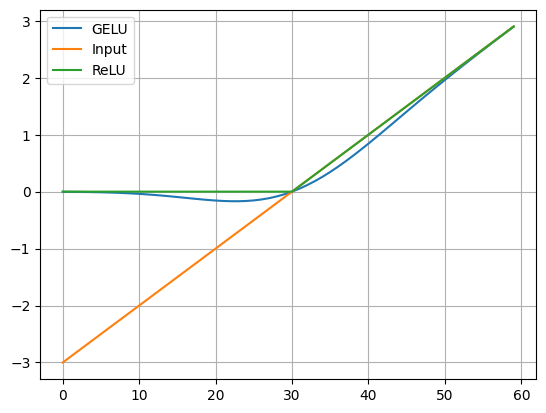

In [71]:
gelu = GELU()
inp_ = torch.arange(-3,3,step=0.1, dtype=torch.float32)
gelu_out = gelu(inp_)
plt.plot(GELU()(inp_), label = "GELU")
plt.plot(inp_, label = "Input")
plt.plot(torch.nn.ReLU()(inp_), label = "ReLU")
plt.grid('on')
plt.legend();

In [72]:
class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        embedding_dim = config.get("embedding_dim")
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, 4 * embedding_dim), # moves the input to a high dimensional space
            GELU(),
            torch.nn.Linear(4 * embedding_dim, embedding_dim)# move the activation back to embedding dimension space
        )
    def forward(self, x):
        return self.layers(x)

In [73]:
from pprint import pprint
pprint(GPT2_CONFIG)

{'context_len': 1024,
 'drop_rate': 0.4,
 'dropout_rate': 0.0,
 'embedding_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'q_k_v_bias': False,
 'vocab_size': 50257}


In [74]:
batch = torch.randn(3,5, 768)
ffd = FeedForward(GPT2_CONFIG)
torchinfo.summary(ffd)

Layer (type:depth-idx)                   Param #
FeedForward                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,362,368
│    └─GELU: 2-2                         --
│    └─Linear: 2-3                       2,360,064
Total params: 4,722,432
Trainable params: 4,722,432
Non-trainable params: 0

In [75]:
with torch.inference_mode(): # to switch-off gradient tracking
    out_ = ffd(batch)
out_.shape

torch.Size([3, 5, 768])

### Shortcut Connections

In [76]:
class SkipConn(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.feed_1 = FeedForward(GPT2_CONFIG)
        self.feed_2 = FeedForward(GPT2_CONFIG)
    def forward(self, inp):
        out_1 = self.feed_1(inp)
        out_1+= inp # skip connection
        out_2 = self.feed_2(out_1)
        out_2+= out_1# skip connection
        return out_2


In [77]:
sc = SkipConn()
torchinfo.summary(sc)

Layer (type:depth-idx)                   Param #
SkipConn                                 --
├─FeedForward: 1-1                       --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  2,362,368
│    │    └─GELU: 3-2                    --
│    │    └─Linear: 3-3                  2,360,064
├─FeedForward: 1-2                       --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-4                  2,362,368
│    │    └─GELU: 3-5                    --
│    │    └─Linear: 3-6                  2,360,064
Total params: 9,444,864
Trainable params: 9,444,864
Non-trainable params: 0

In [78]:
batch.shape

torch.Size([3, 5, 768])

In [79]:
with torch.no_grad():
    out_ = sc(batch)
print(out_.shape)

torch.Size([3, 5, 768])


### Complete GPT-2 Model code

In [80]:
pprint(GPT2_CONFIG)

{'context_len': 1024,
 'drop_rate': 0.4,
 'dropout_rate': 0.0,
 'embedding_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'q_k_v_bias': False,
 'vocab_size': 50257}


In [81]:


class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embedding_dim"],
            d_out=cfg["embedding_dim"],
            context_length=cfg["context_len"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["embedding_dim"])
        self.norm2 = LayerNorm(cfg["embedding_dim"])
        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.att(x)["context_vectors"]   # Shape [batch_size, num_tokens, emb_size]
        # print(type(x))
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


In [82]:
class GPT2(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.emb_layer = torch.nn.Embedding(self.config.get('vocab_size'),
                                            self.config.get('embedding_dim'))
        self.pos_enc_layer = torch.nn.Embedding(self.config.get("context_len"),
                                                self.config.get("embedding_dim"))
        self.drop_emb_layer = torch.nn.Dropout(self.config.get('dropout_rate'))

        # Transformer Blocks
        self.trf_blocks = torch.nn.Sequential(*[TransformerBlock(GPT2_CONFIG) \
                                                for _ in range(self.config.get("n_layers"))])
        # LayerNorm
        self.final_norm = LayerNorm(self.config.get("embedding_dim"))

        # output head
        self.out_head = torch.nn.Linear(self.config.get("embedding_dim"),
                                        self.config.get("vocab_size"))

    def forward(self, inp_):
        batch_size, seq_len = inp_.shape
        tok_emb = self.emb_layer(inp_)
        pos_emb = self.pos_enc_layer(torch.arange(seq_len, device = inp_.device))
        inp_emb = tok_emb + pos_emb
        inp_emb = self.drop_emb_layer(inp_emb)
        x = self.trf_blocks(inp_emb)
        x = self.final_norm(x)
        logits = self.out_head(x) # (batch_size X seq_len X vocab_size)
        return logits

In [83]:
gpt = GPT2(GPT2_CONFIG)
gpt

GPT2(
  (emb_layer): Embedding(50257, 768)
  (pos_enc_layer): Embedding(1024, 768)
  (drop_emb_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.4, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()

In [84]:
torchinfo.summary(gpt)

Layer (type:depth-idx)                   Param #
GPT2                                     --
├─Embedding: 1-1                         38,597,376
├─Embedding: 1-2                         786,432
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      28,311,552
│    │    └─FeedForward: 3-2             4,722,432
│    │    └─LayerNorm: 3-3               1,536
│    │    └─LayerNorm: 3-4               1,536
│    │    └─Dropout: 3-5                 --
│    └─TransformerBlock: 2-2             --
│    │    └─MultiHeadAttention: 3-6      28,311,552
│    │    └─FeedForward: 3-7             4,722,432
│    │    └─LayerNorm: 3-8               1,536
│    │    └─LayerNorm: 3-9               1,536
│    │    └─Dropout: 3-10                --
│    └─TransformerBlock: 2-3             --
│    │    └─MultiHeadAttention: 3-11     28,311,552
│    │    └─FeedForward: 3-12            4,722,432
│

In [93]:
def model_inference(model, idx, max_new_tokens, context_size):
    # idx: batch_size X seq_len
    for  _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]

        with torch.inference_mode():
            logits = model(idx_cond) # (batch_size x contex_len x vocab_size)
            # since we are only interesteed in the output of last token
            logits = logits[:,-1,:] # (batch_size x vocab_size)
            # logits --> probabilities
            probs= torch.softmax(logits,dim=-1) # (batch_size x vocab_size)
            tok_idx = torch.argmax(probs, dim=-1, keepdim=True) # (batch_size x 1)
            # print(tok_idx.shape)
            # print(idx.shape)
        idx = torch.concat([idx,tok_idx], dim = 1)
    return idx


In [106]:
text = ["hello how are you",
        "do you drink tea"]
inp = tokenizer_subword.encode_batch(text)
inp_tensor = torch.tensor(inp)
print(inp_tensor.shape)


torch.Size([2, 4])


In [107]:
tokenizer_subword.decode_batch(model_inference(gpt, inp_tensor, 10, 1024).detach().numpy())

['hello how are you Manafort sharelo dispos575System SHALL sizeofModLoaderware',
 'do you drink teailles Cree attackers psi shockingutil Attack756CPUORD']